In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Sentime

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Sentime


In [20]:
data = pd.read_csv("2020_04_26_dataset.csv")
data = data[data['sentiment'] != 'NEUTRAL']
data = data[data['sentiment'] != 'MIXED']

# Preprocess
# data['tweet'] = data['tweet'].apply(lambda x: re.sub(r'pic.twitter\S+', '', x))
# data['tweet'] = data['tweet'].apply(lambda x:re.sub(r'https?:\/\/.*[\r\n]*', '', x))
# data['tweet'] = data['tweet'].apply(lambda x:re.sub(r'@[A-Za-z0-9]+', '', x))
# data['tweet'] = data['tweet'].apply(lambda x: x.lower())
# data['tweet'] = data['tweet'].apply((lambda x: re.sub(r'[^a-zA-z0-9\s]', '', x)))

print(data[ data['sentiment'] == 'POSITIVE'].size)
print(data[ data['sentiment'] == 'NEGATIVE'].size)

334
238


In [21]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X)

Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(228, 57) (228, 2)
(58, 57) (58, 2)


In [22]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 57, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 57, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
batch_size = 32
epochs = 7
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

Train on 228 samples, validate on 58 samples
Epoch 1/7
228/228 [==============================] - 1s 5ms/step - loss: 0.2483 - accuracy: 0.9342 - val_loss: 0.6508 - val_accuracy: 0.6034
Epoch 2/7
228/228 [==============================] - 1s 4ms/step - loss: 0.1949 - accuracy: 0.9868 - val_loss: 0.6405 - val_accuracy: 0.6724
Epoch 3/7
228/228 [==============================] - 1s 4ms/step - loss: 0.1092 - accuracy: 0.9912 - val_loss: 0.7120 - val_accuracy: 0.6552
Epoch 4/7
228/228 [==============================] - 1s 5ms/step - loss: 0.0668 - accuracy: 0.9912 - val_loss: 0.7060 - val_accuracy: 0.6552
Epoch 5/7
228/228 [==============================] - 1s 4ms/step - loss: 0.0432 - accuracy: 0.9956 - val_loss: 0.8156 - val_accuracy: 0.6379
Epoch 6/7
228/228 [==============================] - 1s 4ms/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.8506 - val_accuracy: 0.6379
Epoch 7/7
228/228 [==============================] - 1s 4ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss

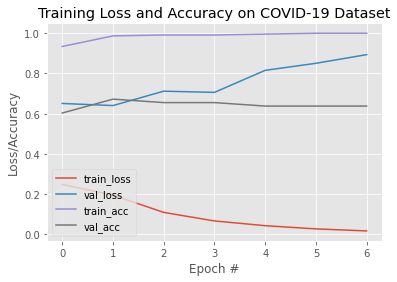

In [26]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [27]:
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

58/58 [==============================] - 0s 394us/step
Test score: 0.8936653013887077
Test accuracy: 0.6379310488700867
